In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile

2024-05-16 00:28:07.363647: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 00:28:07.363706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 00:28:07.365091: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = '/kaggle/input/final-stage-3-v3/Stage 3 V3'

In [3]:
def resize_with_padding(img):
    w, h = img.shape[1], img.shape[0]
    if h > w:
        new_h = 299
        new_w = int(w * (299 / h))
    else:
        new_w = 299
        new_h = int(h * (299 / w))
    
    img = tf.image.resize(img, [new_h, new_w])
    img = tf.image.resize_with_pad(img, 299, 299)
    
    return img

In [4]:
temp_dir = tempfile.mkdtemp()

class_names = os.listdir(dataset_path)

os.makedirs(temp_dir + '/train')
os.makedirs(temp_dir + '/val')
os.makedirs(temp_dir + '/test')

for class_name in class_names:
    os.makedirs(temp_dir + '/train/' + class_name)
    os.makedirs(temp_dir + '/val/' + class_name)
    os.makedirs(temp_dir + '/test/' + class_name)
    
    image_names = os.listdir(dataset_path + '/' + class_name)
    np.random.shuffle(image_names)
    
    train_names = image_names[:int(len(image_names)*0.8)]
    val_names = image_names[int(len(image_names)*0.8):int(len(image_names)*0.9)]
    test_names = image_names[int(len(image_names)*0.9):]

    for name in train_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/train/' + class_name + '/' + name)
    for name in val_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/val/' + class_name + '/' + name)
    for name in test_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/test/' + class_name + '/' + name)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=resize_with_padding
)

train_generator = datagen.flow_from_directory(
    temp_dir + '/train',
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary'
)

validation_generator = datagen.flow_from_directory(
    temp_dir + '/val',
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    temp_dir + '/test',
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary'
)

Found 1292 images belonging to 2 classes.
Found 162 images belonging to 2 classes.
Found 163 images belonging to 2 classes.


In [5]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))  # InceptionV3 expects input size of (299, 299)

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=150,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystop])

Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715819393.585028     496 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.5759 - loss: 0.8708
Epoch 1: val_loss improved from inf to 0.40194, saving model to best_model.keras


W0000 00:00:1715819485.310819     496 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


81/81 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.5767 - loss: 0.8692 - val_accuracy: 0.8519 - val_loss: 0.4019
Epoch 2/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8115 - loss: 0.4495
Epoch 2: val_loss improved from 0.40194 to 0.30357, saving model to best_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 385ms/step - accuracy: 0.8115 - loss: 0.4494 - val_accuracy: 0.8642 - val_loss: 0.3036
Epoch 3/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8631 - loss: 0.3126
Epoch 3: val_loss improved from 0.30357 to 0.25568, saving model to best_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 383ms/step - accuracy: 0.8631 - loss: 0.3126 - val_accuracy: 0.9136 - val_loss: 0.2557
Epoch 4/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9062 - loss: 0.2428
Epoch 4: val_loss did not improve from 0.25568
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 324ms/step - accuracy: 0.9061 - loss: 0.2431 - val_accuracy: 0.8951 - val_loss: 0.2618
Epoch 5/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step

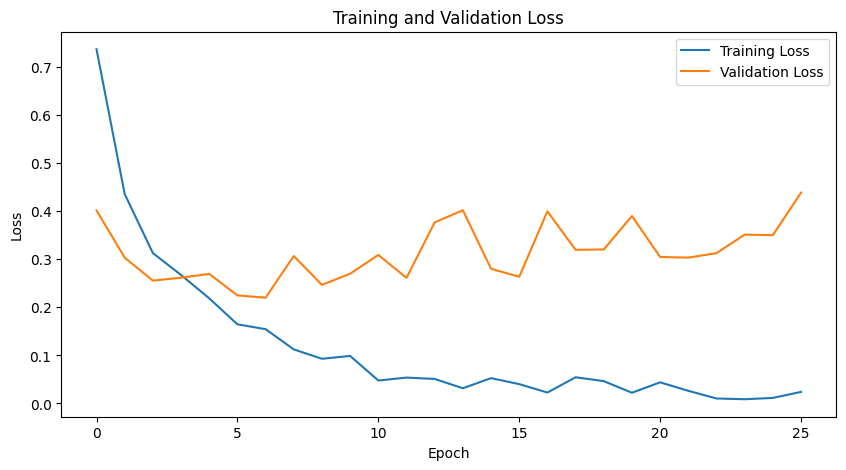

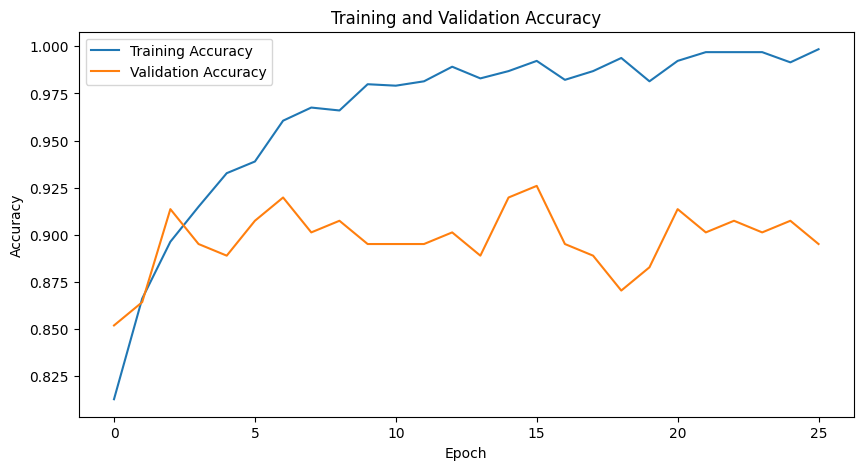

In [7]:
max_loss_threshold = 2.0
min_accuracy_threshold = 0.8

filtered_train_loss = [v for v in history.history['loss'] if v <= max_loss_threshold]
filtered_val_loss = [v for v in history.history['val_loss'] if v <= max_loss_threshold]

filtered_train_accuracy = [v for v in history.history['accuracy'] if v >= min_accuracy_threshold]
filtered_val_accuracy = [v for v in history.history['val_accuracy'] if v >= min_accuracy_threshold]

min_len = min(len(filtered_train_loss), len(filtered_val_loss), len(filtered_train_accuracy), len(filtered_val_accuracy))
filtered_train_loss = filtered_train_loss[:min_len]
filtered_val_loss = filtered_val_loss[:min_len]
filtered_train_accuracy = filtered_train_accuracy[:min_len]
filtered_val_accuracy = filtered_val_accuracy[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(filtered_train_loss, label='Training Loss')
plt.plot(filtered_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(filtered_train_accuracy, label='Training Accuracy')
plt.plot(filtered_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [8]:
model.load_weights('best_model.keras')

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 923ms/step - accuracy: 0.8798 - loss: 0.3155
Test Loss: 0.2390, Test Accuracy: 0.90%


W0000 00:00:1715820277.301355     494 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
